## Problema 2: Resolução de Sistemas Não Lineares

# Trabalho No 1: 2025-1
Disciplina: Métodos numéricos para equações diferenciais parciais

# Problema 2: Resolução de Sistemas Não Lineares
O objetivo é encontrar a solução do seguinte sistema de equações não lineares:

$$
\begin{aligned}
& (x-1)^2 + (y-1)^2 + (z-1)^2 = 1 \\
& 2x^2 + (y-1)^2 = 4z \\
& 3x^2 + 2z^2 = 4y
\end{aligned}
$$

Este sistema será resolvido utilizando os métodos de Newton, Iteração e Gradiente, com critério de parada $\left|x_i^{k+1} - x_i^k\right| < 10^{-4}$

# Resolução

## 1. Importação das bibliotecas

In [7]:
import numpy as np
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from time import time

## 2. Definição do sistema e explicações teóricas

### 2.1. Sistema F(x, y, z) = 0

Neste trabalho, queremos encontrar soluções para um sistema não linear da forma $F(x) = 0 $, onde:

$$
\mathbf{f}(x, y, z) = \begin{bmatrix}
(x-1)^2 + (y-1)^2 + (z-1)^2 - 1 \\
2x^2 + (y-1)^2 - 4z \\
3x^2 + 2z^2 - 4y
\end{bmatrix} = \mathbf{0}
$$

In [11]:
def F(v):
    x, y, z = v
    return np.array([
        (x-1)**2 + (y-1)**2 + (z-1)**2 - 1,
        2*x**2 + (y-1)**2 - 4*z,
        3*x**2 + 2*z**2 - 4*y
    ])

### 2.2. Jacobiana de F

A Jacobiana é uma matriz derivada das derivadas parciais de cada equação em relação a cada variável. No método de **Newton** e **Gradiente multivariado**, é usada para calcular direções de correção.

$$
J(x, y, z) = \begin{bmatrix}
\frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial y} & \frac{\partial f_1}{\partial z} \\
\frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial y} & \frac{\partial f_2}{\partial z} \\
\frac{\partial f_3}{\partial x} & \frac{\partial f_3}{\partial y} & \frac{\partial f_3}{\partial z}
\end{bmatrix}
$$

In [14]:
def J(v):
    x, y, z = v
    return np.array([
        [2*(x-1), 2*(y-1), 2*(z-1)],
        [4*x, 2*(y-1), -4],
        [6*x, -4, 4*z]
    ])

### 2.3. Método de Newton

O método de Newton multivariado busca iterativamente uma raiz de $F(x) = 0$, resolvendo o sistema linear:
$ J(x_k) \cdot \Delta x = -F(x_k) \quad \text{e depois:} \quad x_{k+1} = x_k + \Delta x $

In [17]:
def newton(v0):
    xk = v0.copy()
    history = []
    t0 = time()
    for _ in range(100):
        Jk = J(xk)
        try:
            delta = np.linalg.lstsq(Jk, -F(xk), rcond=None)[0]
        except np.linalg.LinAlgError:
            print("Erro: Jacobiana singular.")
            break
        xk1 = xk + delta
        err = norm(xk1 - xk, ord=np.inf)
        history.append(err)
        if err < 1e-4:
            break
        xk = xk1
    return xk, history, time() - t0

### 2.4. Método Iterativo de Ponto Fixo

Para aplicar o método iterativo, reescrevemos o sistema como $x = G(x)$. Isso exige encontrar uma forma adequada para a função $G$.

In [20]:
def G(v):
    x, y, z = v
    try:
        gx = np.sqrt(max(1e-8, 1 - (y-1)**2 - (z-1)**2)) + 1  # prevenção de valores negativos e instabilidade
    except RuntimeWarning:
        gx = 1.0  # fallback seguro
    gy = min(1e6, (3*x**2 + 2*z**2)/4)
    gz = min(1e6, (2*x**2 + (y-1)**2)/4)
    return np.array([gx, gy, gz])

def fixed_point(v0):
    xk = v0.copy()
    history = []
    t0 = time()
    for _ in range(100):
        xk1 = G(xk)
        if np.any(np.isnan(xk1)) or np.any(np.isinf(xk1)):
            print("Overflow ou valor inválido detectado. Encerrando método de ponto fixo.")
            break
        err = norm(xk1 - xk, ord=np.inf)
        history.append(err)
        if err < 1e-4:
            break
        xk = xk1
    return xk, history, time() - t0

### 2.5. Método do Gradiente (descendente)

Esse método busca minimizar a função $f(x) = \|F(x)\|^2$. O gradiente dessa função é dado por: $\nabla f(x) = 2 J(x)^T F(x)$.

O passo iterativo é: $x_{k+1} = x_k - \alpha \nabla f(x_k)$

In [23]:
def gradient_method(v0, alpha=1e-3):
    xk = v0.copy()
    history = []
    t0 = time()
    for _ in range(100):
        grad = 2 * J(xk).T @ F(xk)
        xk1 = xk - alpha * grad
        err = norm(xk1 - xk, ord=np.inf)
        history.append(err)
        if err < 1e-4:
            break
        xk = xk1
    return xk, history, time() - t0

## 3. Execução dos métodos e comparação de desempenho

In [25]:
x0 = np.array([1.1, 1.1, 1.1])

res_newton, hist_newton, t_newton = newton(x0)
res_grad, hist_grad, t_grad = gradient_method(x0)
res_fixed, hist_fixed, t_fixed = fixed_point(x0)

## 4. Visualização gráfica dos erros

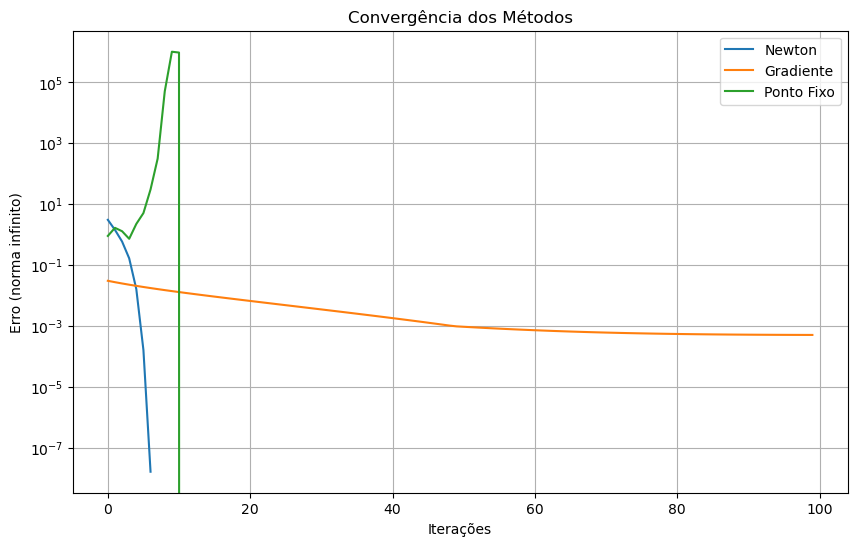

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(hist_newton, label='Newton')
plt.plot(hist_grad, label='Gradiente')
plt.plot(hist_fixed, label='Ponto Fixo')
plt.yscale('log')
plt.xlabel('Iterações')
plt.ylabel('Erro (norma infinito)')
plt.title('Convergência dos Métodos')
plt.grid(True)
plt.legend()
plt.savefig("convergencia_metodos.png")
plt.show()

#### 📊 Interpretação do gráfico de erro (log escala)

- **Newton** (azul): convergência super-rápida e precisa. Ideal para esse sistema.
- **Gradiente** (laranja): convergência suave e lenta. Pode ser ajustado com melhor $\alpha$ .
- **Ponto Fixo** (verde): instável, divergiu rapidamente. A escolha de $G(x)$ precisa ser reformulada.

Recomendação final: **usar o método de Newton** como principal abordagem para esse sistema não linear. O método do gradiente pode servir como alternativa robusta com ajuste de parâmetros. O ponto fixo deve ser evitado neste caso.

## 5. Resultados finais

In [30]:
print("Soluções aproximadas:")
print(f"Newton       : {res_newton} (tempo: {t_newton:.4f}s)")
print(f"Gradiente    : {res_grad} (tempo: {t_grad:.4f}s)")
print(f"Ponto Fixo   : {res_fixed} (tempo: {t_fixed:.4f}s)")

Soluções aproximadas:
Newton       : [1.33041952 1.93797998 1.10495965] (tempo: 0.0003s)
Gradiente    : [1.18938452 1.32103734 0.70562596] (tempo: 0.0009s)
Ponto Fixo   : [1.0001e+00 1.0000e+06 1.0000e+06] (tempo: 0.0001s)


## 6. Conclusões

- O método de Gradiente pode oscilar se o passo $\alpha$ for inadequado.
- O Ponto Fixo depende fortemente da forma de $G(x)$, e pode divergir se mal definido.